In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [68]:
from config import DATA_DIR
ml_file = PROJECT_ROOT / DATA_DIR / "processed" / "features_for_ml.csv"

figures_dir = PROJECT_ROOT / "figures" / "testing"
os.makedirs(figures_dir, exist_ok=True)

In [69]:
ml_df = pd.read_csv(ml_file)

**H1: Seasonality:**
Hazelnut prices exhibit strong seasonal patterns aligned with harvest.

H1 ANOVA F-statistic: 14.168052301057191
H1 p-value: 3.293562220245079e-09


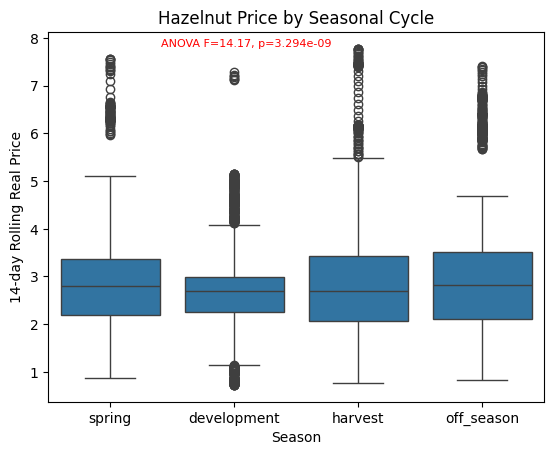

In [76]:
# ANOVA: rolling_14d_adjusted price vs season
anova_result = stats.f_oneway(
    ml_df.loc[ml_df['season_spring'] == 1, 'rolling_14d_adjusted'],
    ml_df.loc[ml_df['season_development'] == 1, 'rolling_14d_adjusted'],
    ml_df.loc[ml_df['season_harvest'] == 1, 'rolling_14d_adjusted'],
    ml_df.loc[ml_df['season_off_season'] == 1, 'rolling_14d_adjusted']
)

f_stat = anova_result.statistic
p_val = anova_result.pvalue

print("H1 ANOVA F-statistic:", f_stat)
print("H1 p-value:", p_val)

ml_df_plot = ml_df.copy()

ml_df_plot['season_label'] = np.select(
    [ml_df_plot['season_spring'] == 1,
    ml_df_plot['season_development'] == 1,
    ml_df_plot['season_harvest'] == 1],
    ['spring', 'development', 'harvest'],
    default='off_season'
)

ax = sns.boxplot(
    x='season_label',
    y='rolling_14d_adjusted',
    data=ml_df_plot,
    order=['spring', 'development', 'harvest', 'off_season']
)

text_x = 1.1
text_y = ml_df_plot['rolling_14d_adjusted'].max() 

ax.text(
    text_x, text_y,
    f"ANOVA F={f_stat:.2f}, p={p_val:.3e}",
    ha='center', va='bottom',
    fontsize=8,
    color='red'
)


plt.title("Hazelnut Price by Seasonal Cycle")
plt.xlabel("Season")
plt.ylabel("14-day Rolling Real Price")

plt.savefig(figures_dir / "h1-hazelnut-price-by-seasons.png")
plt.show()

**H2 - Weather Impact:**
Lagged weather affects prices (temperature, precipitation, etc.).

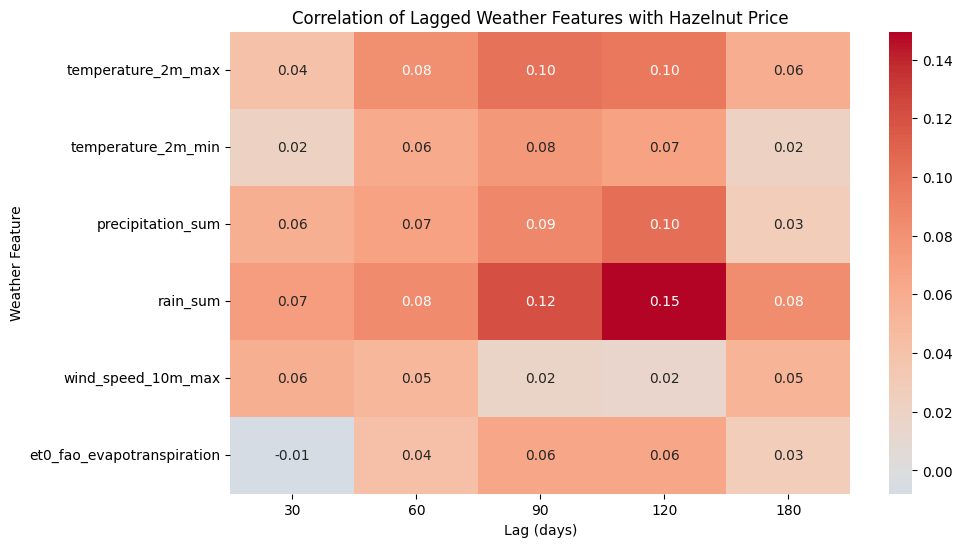

In [77]:
weather_lags = [col for col in ml_df.columns if '_lag' in col]
price_col = 'rolling_14d_adjusted'

corr_results = []

for col in weather_lags:
    # double check NA vals
    valid_idx = ml_df[[price_col, col]].dropna().index
    corr, pval = stats.pearsonr(ml_df.loc[valid_idx, price_col],
                                 ml_df.loc[valid_idx, col])
    corr_results.append((col, corr, pval))

corr_df = pd.DataFrame(corr_results, columns=['Feature', 'Pearson_r', 'p_value'])
corr_df = corr_df.sort_values(by='Pearson_r', key=abs, ascending=False)

price_col = 'rolling_14d_adjusted'

weather_features = ['temperature_2m_max', 'temperature_2m_min',
                    'precipitation_sum', 'rain_sum',
                    'wind_speed_10m_max', 'et0_fao_evapotranspiration']

lags = [30, 60, 90, 120, 180]

heatmap_data = pd.DataFrame(index=weather_features, columns=lags)

for feat in weather_features:
    for lag in lags:
        col_name = f"{feat}_{lag}d_lag"
        # double check NA vals
        valid_idx = ml_df[[price_col, col_name]].dropna().index
        if len(valid_idx) > 0:
            corr, _ = stats.pearsonr(ml_df.loc[valid_idx, price_col],
                                     ml_df.loc[valid_idx, col_name])
            heatmap_data.loc[feat, lag] = corr
        else:
            heatmap_data.loc[feat, lag] = np.nan


heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation of Lagged Weather Features with Hazelnut Price")
plt.xlabel("Lag (days)")
plt.ylabel("Weather Feature")

plt.savefig(figures_dir / "h2-corr-lagged-weather-w-prices.png")
plt.show()

**H3 – Currency:**
USD/TRY normalization reduces price volatility.

In [38]:
ml_df['usd_tl_30d_return'] = ml_df['USD_TL'].pct_change(30)

ml_df['currency_regime'] = np.where(
    ml_df['usd_tl_30d_return'] > 0.05,
    'depreciation',
    np.where(
        ml_df['usd_tl_30d_return'] < -0.05,
        'appreciation',
        'stable'))

ml_df['rolling_14d_nominal'] = ml_df['rolling_14d_adjusted'] * ml_df['USD_TL']

anova_nominal = stats.f_oneway(
    ml_df.loc[ml_df['currency_regime'] == 'depreciation', 'rolling_14d_nominal'].dropna(),
    ml_df.loc[ml_df['currency_regime'] == 'stable', 'rolling_14d_nominal'].dropna(),
    ml_df.loc[ml_df['currency_regime'] == 'appreciation', 'rolling_14d_nominal'].dropna()
)

t_stat, p_val = anova_nominal
print("Anova for nominal price")
print(f"stats:", t_stat)
print(f"p_val:",p_val)
print()

anova_real = stats.f_oneway(
    ml_df.loc[ml_df['currency_regime'] == 'depreciation', 'rolling_14d_adjusted'].dropna(),
    ml_df.loc[ml_df['currency_regime'] == 'stable', 'rolling_14d_adjusted'].dropna(),
    ml_df.loc[ml_df['currency_regime'] == 'appreciation', 'rolling_14d_adjusted'].dropna()
)

t_stat, p_val = anova_real
print("Anova for adjusted price")
print(f"stats:", t_stat)
print(f"p_val:",p_val)


Anova for nominal price
stats: 77.94609526403741
p_val: 2.792047140710521e-34

Anova for adjusted price
stats: 184.03409779698748
p_val: 5.0982389932439895e-79


**H4 – Seasonal Public Interest:**
Google search interest for “fındık fiyatı” in Türkiye is higher during the harvest season compared to off-season periods.

In [79]:
stat, p_val = stats.kruskal(
    ml_df_plot.loc[ml_df_plot['season_spring'] == 1, 'trend'].dropna(),
    ml_df_plot.loc[ml_df_plot['season_development'] == 1, 'trend'].dropna(),
    ml_df_plot.loc[ml_df_plot['season_harvest'] == 1, 'trend'].dropna(),
    ml_df_plot.loc[ml_df_plot['season_off_season'] == 1, 'trend'].dropna()
)

print("H4 – Season Relation of Google Trends")
print("Kruskal-Wallis Stat:", stat)
print("p-value:", p_val)

H4 – Season Relation of Google Trends
Kruskal-Wallis Stat: 635.033066273118
p-value: 2.5606030688423035e-137


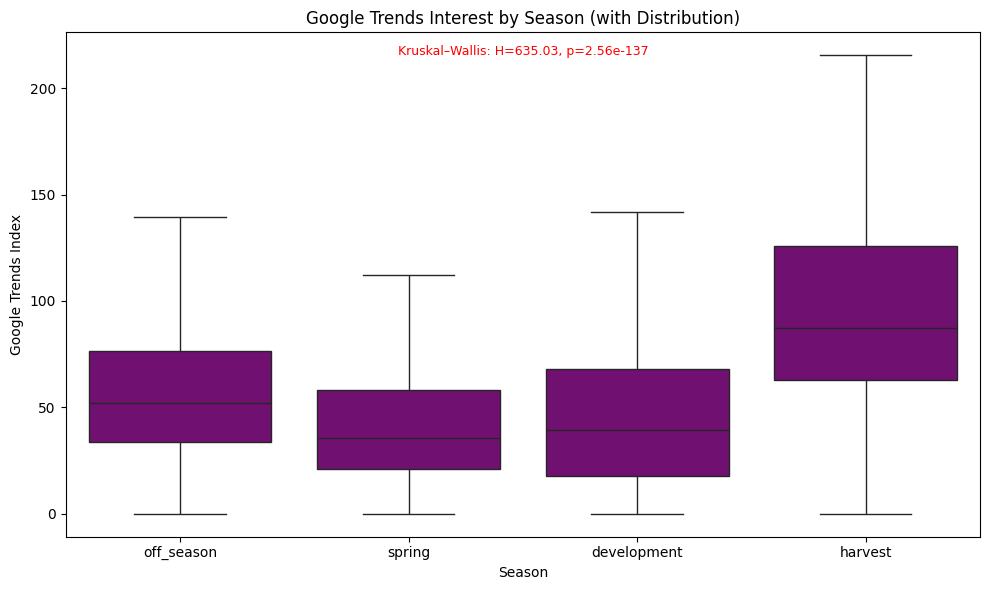

In [89]:
ml_df_plot['season_label'] = np.select(
    [
        ml_df_plot['season_spring'] == 1,
        ml_df_plot['season_development'] == 1,
        ml_df_plot['season_harvest'] == 1,
    ],
    ['spring', 'development', 'harvest'],
    default='off_season'
)

plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    x='season_label',
    y='trend',
    data=ml_df_plot,
    showfliers=False,
    color="purple"
)


ax.text(
    0.5, 0.95,
    f"Kruskal–Wallis: H={stat:.2f}, p={p_val:.2e}",
    transform=ax.transAxes,
    ha='center',
    va='bottom',
    fontsize=9,
    color='red'
)

plt.title("Google Trends Interest by Season (with Distribution)")
plt.xlabel("Season")
plt.ylabel("Google Trends Index")
plt.tight_layout()

plt.savefig(figures_dir / "h4-seasonal-google-trends.png")
plt.show()

**H5 – Price Driven Public Interest:**
Google search interest increases when hazelnut prices are relatively high, reflecting public awareness of price levels.

In [57]:
stat, p_val = stats.spearmanr(ml_df_plot['rolling_14d_adjusted'], ml_df_plot['trend'], nan_policy='omit')

print("H5 – Price Relation of Google Trends")
print("spearman_R:", stat)
print("p-value:", p_val)

H5 – Price Relation of Google Trends
spearman_R: 0.07652824521641774
p-value: 1.1892359478228384e-07
